In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier

data = fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])

In [3]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]
    
    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [4]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                      max_features='sqrt',
                                                      splitter='random'),
                            n_estimators=30,
                            learning_rate=0.1,
                            algorithm='SAMME.R',# since decision tree has predict_proba method, otherwise use SAMME
                            random_state=0 # controls random seed passed to each estimator in each boosted stage
                            )

adaboost_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features='sqrt',
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                        

In [6]:
print(len(adaboost_clf.estimators_)) # array of trained estimators
print(len(adaboost_clf.estimator_weights_)) # estimator weights for each estimator
print(len(adaboost_clf.estimator_errors_)) # classification error for each estimator
print(len(adaboost_clf.feature_importances_))
# no internal type conversion happens here

30
30
30
784


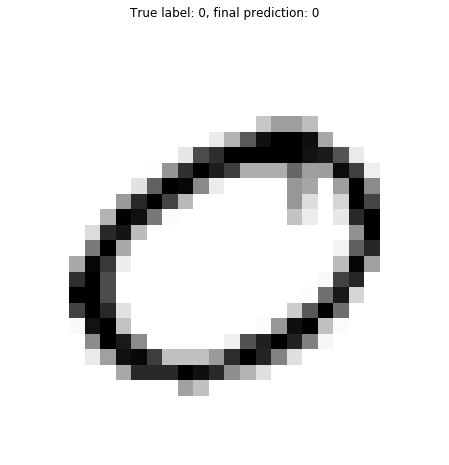

In [5]:
fig = plt.figure(figsize=(8,8))
plt.imshow(X_test.astype(float).values[0,:].reshape(28, -1),cmap=plt.get_cmap('gray_r'))
plt.axis('off')
plt.title("True label: "+str(y_test.iloc[0]) + \
          ", final prediction: " + \
          str(adaboost_clf.predict(X_test.values[0,:].reshape(1,-1))[0]))
plt.show()

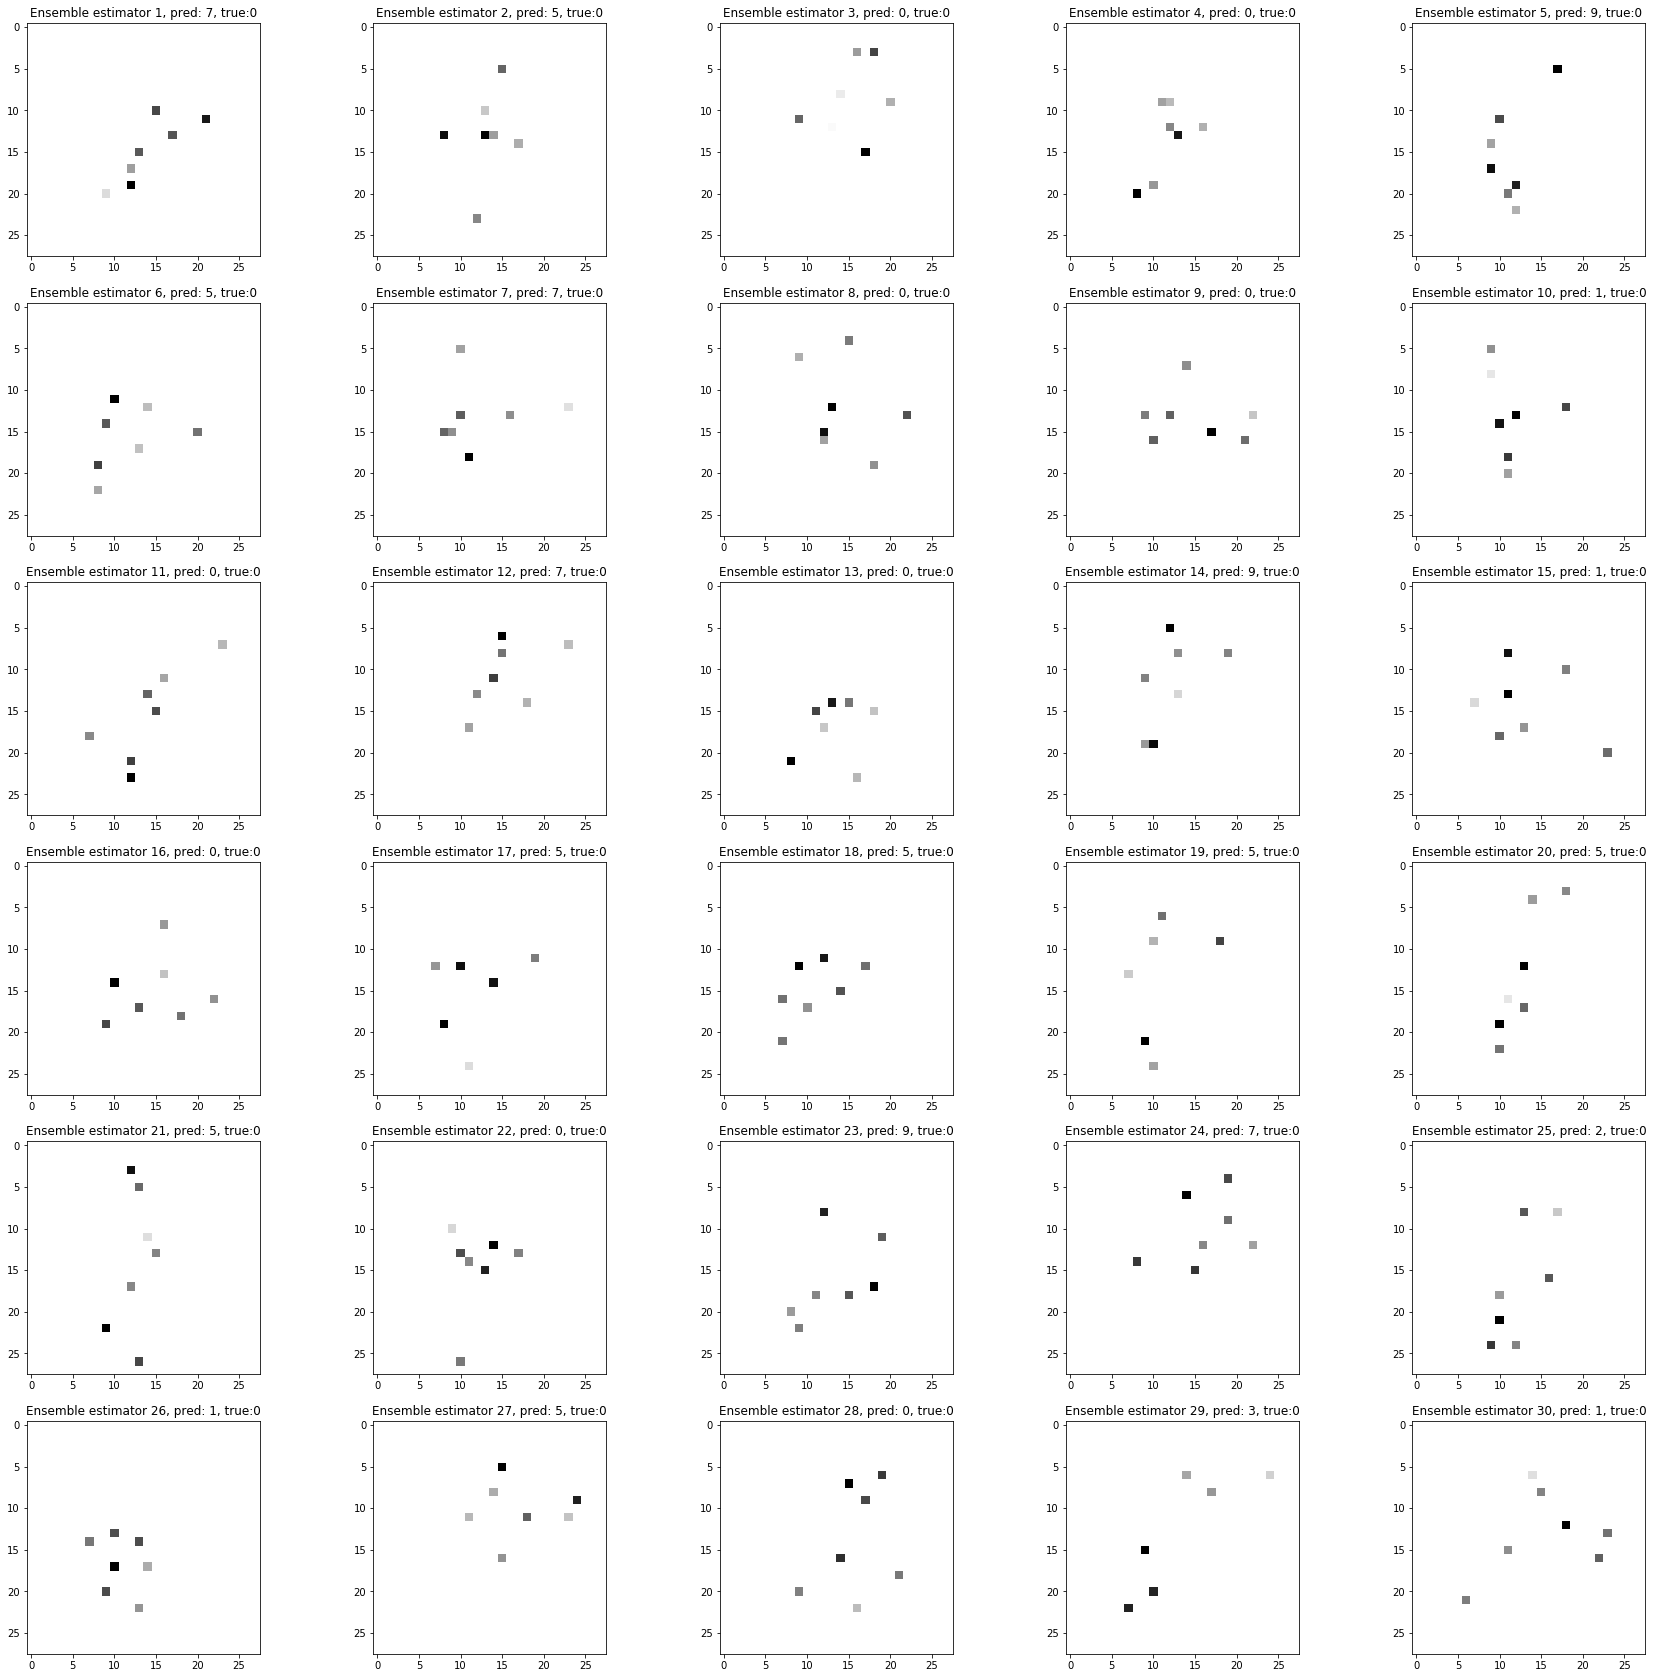

In [6]:
# for showing what each model in our ensemble 'sees'
fig = plt.figure(figsize = (30,30))
for i in range(len(adaboost_clf.estimators_)):
    ax = fig.add_subplot(6,5,i+1)
    est = adaboost_clf.estimators_[i]
    plt.title('Ensemble estimator '+str(i+1) + \
              ", pred: " + str(est.predict(X_test.values[0,:].reshape(1,-1))[0]) + \
              ", true:"+str(y_test.iloc[0]))
    plt.imshow(adaboost_clf.estimators_[i].feature_importances_.reshape(28,-1),
              plt.get_cmap('gray_r'))

plt.show()

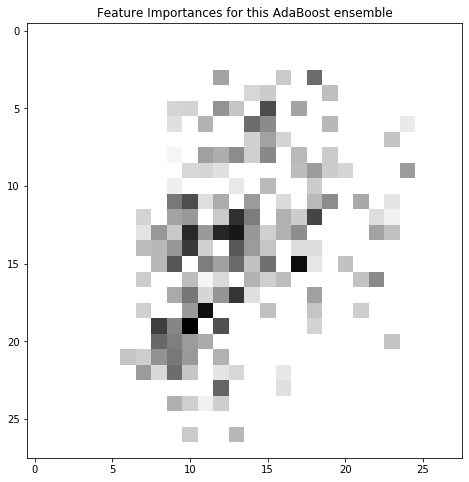

In [7]:
# showing aggregated weighted feature importance region
plt.figure(figsize = (8,8))
plt.title("Feature Importances for this AdaBoost ensemble")
plt.imshow(adaboost_clf.feature_importances_.reshape(28,-1),cmap=plt.get_cmap('gray_r'))
plt.show()
# note that over the whole ensemble the model seems to have identified the major region of interest.
# Our images are centered and orientated, so the numbers mainly appear in the colored region
# Remember: Final prediction is weighted aggregation over individual ensemble, this just shows how much of the
# input data our model covers and considers important as the data passes through the whole ensemble

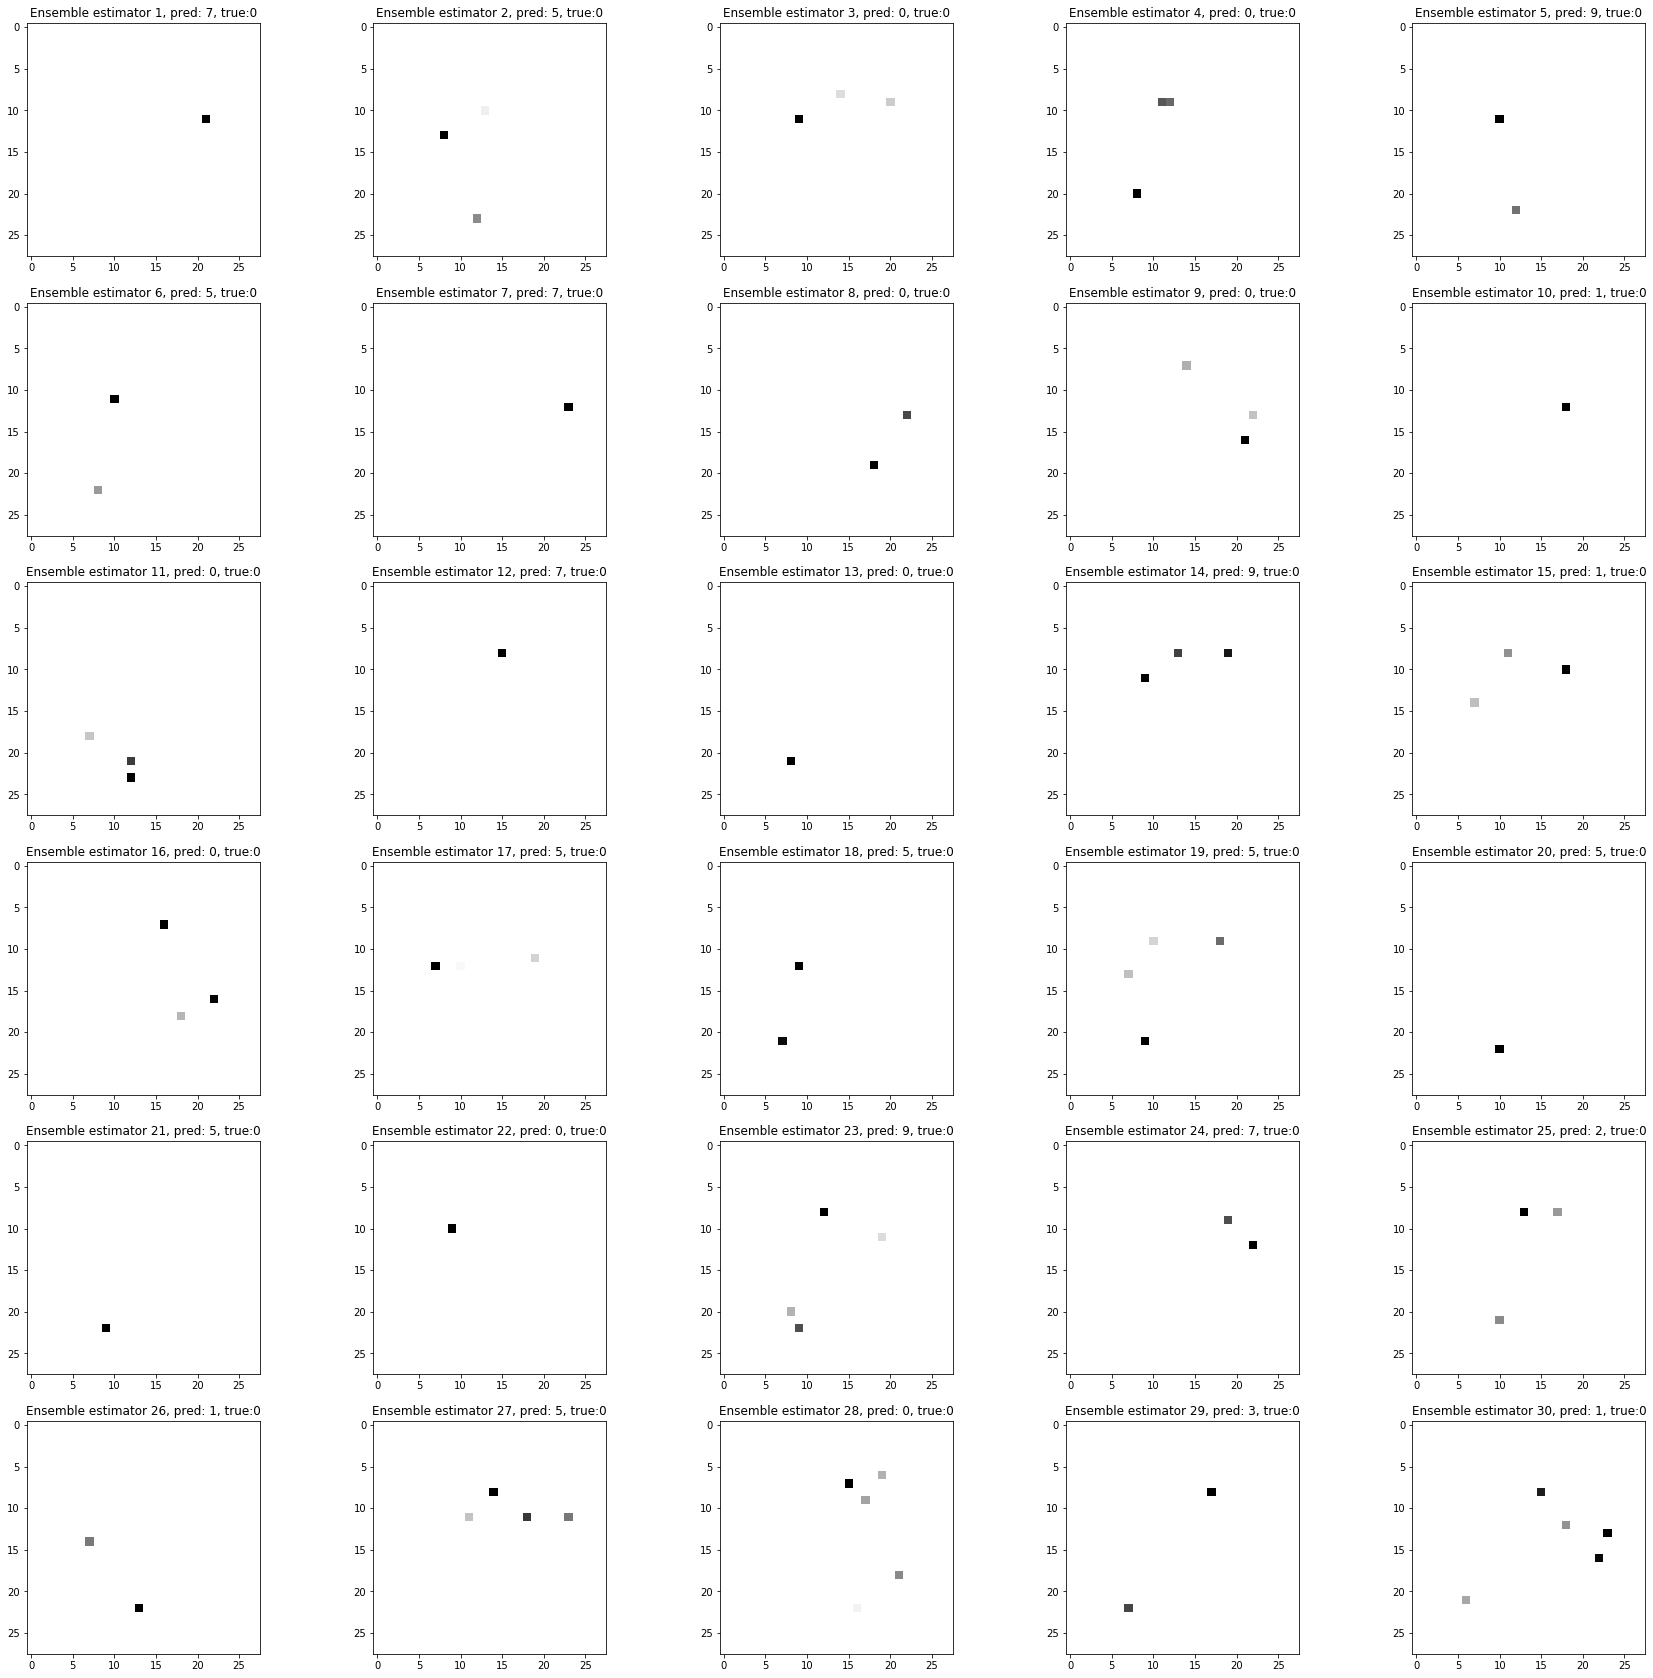

In [8]:
# for tracking what the final model would 'see'
seen = np.zeros((28,28))

fig = plt.figure(figsize = (30,30))
for i in range(len(adaboost_clf.estimators_)):
    ax = fig.add_subplot(6,5,i+1)
    est = adaboost_clf.estimators_[i]
    plt.title('Ensemble estimator '+str(i+1)+", pred: " + str(est.predict(X_test.values[0,:].reshape(1,-1))[0])+", true:"+str(y_test.iloc[0]))
    plt.imshow(adaboost_clf.estimators_[i].feature_importances_.reshape(28,-1) * \
               X_test.astype(float).values[0,:].reshape(28, -1),
               cmap=plt.get_cmap('gray_r'))
    
    seen += adaboost_clf.estimator_weights_[i] * \
            adaboost_clf.estimators_[i].feature_importances_.reshape(28,-1) * \
               X_test.astype(float).values[0,:].reshape(28, -1)
plt.show()

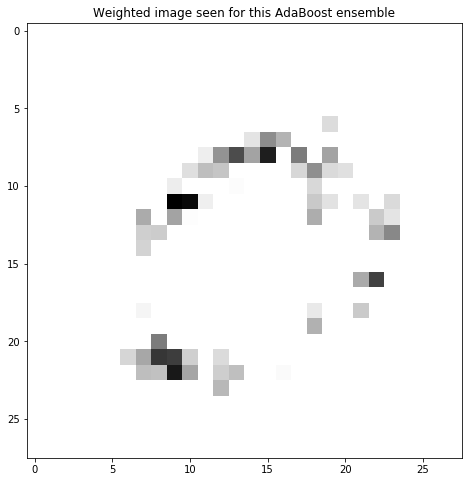

In [9]:
# note to remember: scoring doesn't happen on final aggregated (in this case image) results, 
# but is instead weighted aggregating of individual predictions
# the image here is more for show how, over the ensemble, we the model explores different parts of the image
plt.show()
plt.figure(figsize = (8,8))
plt.title("Weighted image seen for this AdaBoost ensemble")
plt.imshow(seen,cmap=plt.get_cmap('gray_r'))
plt.show()

In [10]:
adaboost_clf.score(X_test, y_test)

0.8245714285714286

In [11]:
#resulting final prediction at each stage of the estimator
stage = 1
for stage_pred, staged_score in zip(adaboost_clf.staged_predict(X_test),
                                    adaboost_clf.staged_score(X_test, y_test)):
    print('stage:',"{0:2d}".format(stage),
          'stage predictions:',stage_pred,
          'staged_score:',"{0:.4f}".format(round(staged_score,4)),
          len(stage_pred))
    stage += 1
# notice that these are different than the individual predictions from each estimator
# at that part of the ensemble

stage:  1 stage predictions: ['7' '0' '9' ... '6' '7' '6'] staged_score: 0.3007 14000
stage:  2 stage predictions: ['5' '0' '4' ... '6' '7' '2'] staged_score: 0.4765 14000
stage:  3 stage predictions: ['0' '0' '4' ... '2' '7' '2'] staged_score: 0.5201 14000
stage:  4 stage predictions: ['0' '0' '9' ... '8' '7' '2'] staged_score: 0.5967 14000
stage:  5 stage predictions: ['0' '0' '9' ... '3' '7' '7'] staged_score: 0.6314 14000
stage:  6 stage predictions: ['5' '0' '9' ... '3' '7' '7'] staged_score: 0.6554 14000
stage:  7 stage predictions: ['5' '0' '9' ... '2' '7' '7'] staged_score: 0.6849 14000
stage:  8 stage predictions: ['0' '0' '9' ... '8' '7' '7'] staged_score: 0.6994 14000
stage:  9 stage predictions: ['0' '0' '9' ... '8' '7' '7'] staged_score: 0.7191 14000
stage: 10 stage predictions: ['0' '0' '9' ... '8' '7' '7'] staged_score: 0.7218 14000
stage: 11 stage predictions: ['0' '0' '9' ... '8' '7' '7'] staged_score: 0.7433 14000
stage: 12 stage predictions: ['0' '0' '9' ... '8' '7' 